In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
import random
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt
import torch
 
from util.test_config import Config
from model.multimodel import MultiModel
from util.dataset.multi_dataset import PV_multi_Dataset
from util.test_config import Config

input shape torch.Size([1, 4, 24, 24, 24])
torch.Size([1, 4, 24, 24, 24])
after conv3d torch.Size([1, 64, 24, 24, 24])
after fc1 torch.Size([24, 1, 128])
after transformer_encoder torch.Size([24, 1, 128])
after fc2 torch.Size([24, 1, 64])
output shape torch.Size([24, 1, 64])


/data/john-home/anaconda3/envs/fed/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
config = Config()
print(config.include_nwp)

gsp_data = np.load('./jq_data/gfs_data.npy')
nwp_data = np.load('./jq_data/nwp_data.npy')

gsp_data.shape,nwp_data.shape

True


((8832, 1), (12, 1, 368, 25, 25))

In [4]:
device = 0

fix_seed = 30912
# fix_seed = 71005
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

data = gsp_data,[nwp_data]
dataset = PV_multi_Dataset(config, data)

row1 = int(0.7 * len(dataset))
row2 = int(0.85 * len(dataset))

train_dataset = Subset(dataset,list(range(row1)))
print(f'训练集长度为{len(train_dataset)}')
vali_dataset = Subset(dataset,list(range(row1,row2)))
print(f'验证集长度为{len(vali_dataset)}')
test_dataset = Subset(dataset,list(range(row2,len(dataset))))
print(f'测试集长度为{len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # 监控验证损失
    dirpath='checkpoints',  # 保存模型的目录
    filename='best_model',  # 文件名模板
    save_top_k=1,  # 只保存最好的模型
    mode='min',  # 选择最小的验证损失
    verbose=True  # 启用日志
)

class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss.append(trainer.callback_metrics["train_loss"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_loss.append(trainer.callback_metrics["val_loss"].item())

loss_history = LossHistory()

model = MultiModel(config).to(device)
trainer = pl.Trainer(max_epochs=500,callbacks=[loss_history,checkpoint_callback])

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=vali_loader)

include_nwp
训练集长度为381
验证集长度为82
测试集长度为82


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/data/john-home/anaconda3/envs/fed/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/john-home/anaconda3/envs/fed/lib/python3.9/sit ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for perfor

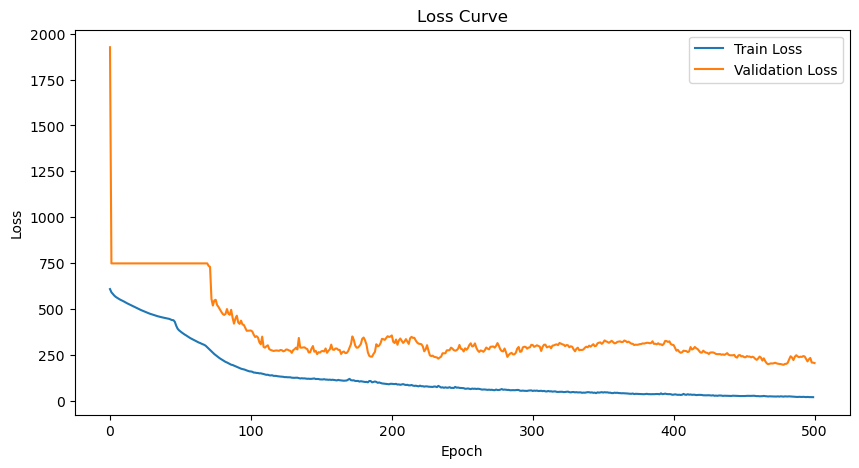

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history.train_loss, label='Train Loss')
plt.plot(loss_history.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

'/data/john-home/Chenn/jq/pvnet_total/MultiSolarPowerNet/checkpoints/best_model-v4.ckpt'

In [43]:

best_model_path = '/data/john-home/Chenn/jq/pvnet_total/MultiSolarPowerNet/checkpoints/best_model.ckpt'
test_model = MultiModel.load_from_checkpoint(checkpoint_path=best_model_path, config=config)

test_model.eval()

/data/john-home/anaconda3/envs/fed/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MultiModel(
  (conv1d_gsp): Conv1d_GSP(
    (convs): Sequential(
      (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): ReLU()
      (10): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (11): ReLU()
    )
    (fc1): Linear(in_features=96, out_features=72, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=72, out_features=72, bias=True)
          )
          (linear1): Linear(in_features=72, out_features=10, b

In [44]:
def model_predict(model, loader):
    model.cpu()  # 确保模型在正确的设备上
    predictions = []
    truth = []
    for i,t in loader:
        model.eval()
        y_pre = model(i)
        predictions.append(y_pre.cpu().detach().numpy())
        truth.append(t.cpu().detach().numpy())
    
    predictions = np.concatenate(predictions)
    truth = np.concatenate(truth)
    return predictions, truth

In [60]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model.to(device)
train_predictions,train_truth = model_predict(test_model,train_loader)
test_predictions,test_truth = model_predict(test_model,test_loader)

# y,t = model_predict(test_model,dataloader)

In [61]:
train_predictions.shape,train_truth.shape,test_predictions.shape,test_truth.shape
# y.shape,t.shape

((381, 1, 5), (381, 5, 1), (82, 1, 5), (82, 5, 1))

In [63]:
train_predictions = np.squeeze(train_predictions)
train_truth = np.squeeze(train_truth)
test_predictions = np.squeeze(test_predictions)
test_truth = np.squeeze(test_truth)

In [62]:
train_predictions = train_predictions.reshape(-1,-1)
train_truth = train_truth.reshape(-1,-1)
test_predictions = test_predictions.reshape(-1,-1)
test_truth = test_truth.reshape(-1,-1)

# y = y.reshape(-1,1)
# t = t.reshape(-1,1)

ValueError: can only specify one unknown dimension

In [64]:
train_predictions.shape,train_truth.shape
# y.shape,t.shape

((381, 5), (381, 5))

In [75]:
t = np.delete(test_truth, 0, axis=1).reshape(-1,1)
y = np.delete(test_predictions, 0, axis=1).reshape(-1,1)

((328, 1), (328, 1))

In [49]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 计算均方误差 (MSE)
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# 计算均方根误差 (RMSE)
def calculate_rmse(y_true, y_pred):
    mse = calculate_mse(y_true, y_pred)
    return np.sqrt(mse)

# 计算平均绝对误差 (MAE)
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# 计算 R 平方值 (R-squared)
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

# 计算绝对百分比误差 (MAPE)，排除 y_true 为零的情况
def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100


# 综合计算多个评估指标
def evaluate_regression_model(y_true, y_pred):
    mse = calculate_mse(y_true, y_pred)
    rmse = calculate_rmse(y_true, y_pred)
    mae = calculate_mae(y_true, y_pred)
    r_squared = calculate_r_squared(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r_squared,
        'MAPE': mape
    }

In [50]:
# x = calculate_mae(train_predictions, train_truth)
# x

In [51]:
y = test_predictions
t = test_truth

In [71]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
scle = MinMaxScaler()
scle.fit(t)
t = scle.transform(t)
y = scle.transform(y)

In [76]:
x = calculate_mae(y,t)
x

5.6513424

In [91]:
com = np.load('./jq_data/com_data.npy')
row = int(com.shape[0]*0.85)
com_test = com[-1312:]
com_test.shape

(1312, 1)

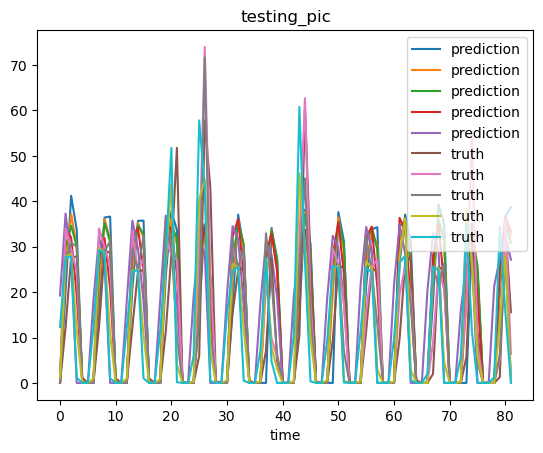

In [105]:
plt.plot(test_predictions, label='prediction')
plt.plot(test_truth, label='truth')
plt.xlabel('time')
plt.title('testing pic')
plt.legend()
plt.show()

# plt.plot(y, label='prediction')
# plt.plot(t, label='truth')

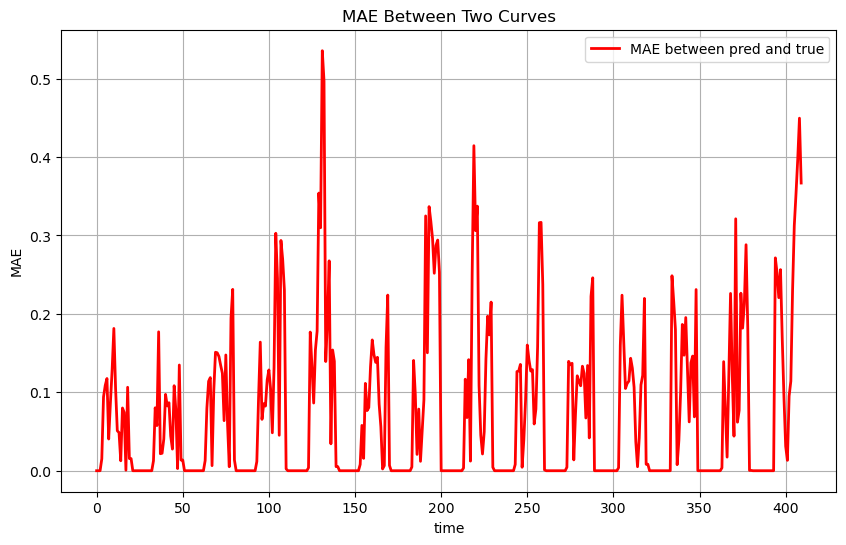

In [56]:
mae = np.abs(y - t)

plt.figure(figsize=(10, 6))
plt.plot(mae, label='MAE between pred and true', color='r', linewidth=2)
plt.title('MAE Between Two Curves')
plt.xlabel('time')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

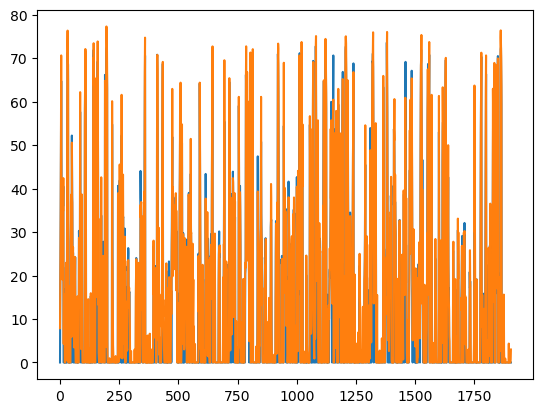

In [57]:
plt.plot(train_predictions, label='prediction')
plt.plot(train_truth, label='truth')

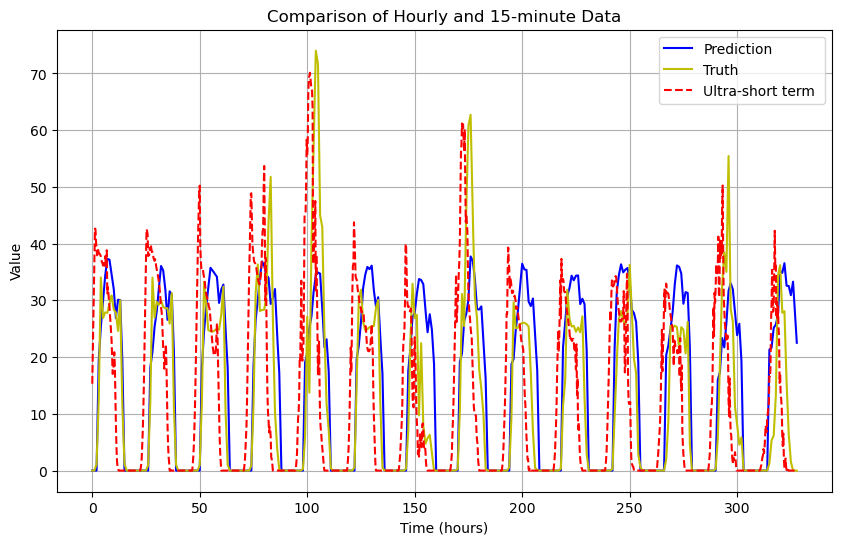

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



# 假设时间从 0 到 327 小时，对于每小时的数据
time_1h = np.arange(0, 328)  # 每小时的时间点

# 对于每15分钟的数据，时间点应该是 0, 0.25, 0.5, ..., 1311*0.25
time_15min = np.arange(0, 328, 0.25)  # 每15分钟的时间点

# 插值：将每小时的数据插值到每15分钟的时间点上
interpolator = interp1d(time_1h, y.flatten(), kind='linear', fill_value='extrapolate')
yy = interpolator(time_15min)  # 得到插值后的每15分钟的数据

interpolator = interp1d(time_1h, t.flatten(), kind='linear', fill_value='extrapolate')
tt = interpolator(time_15min)  # 得到插值后的每15分钟的数据

# 绘图
plt.figure(figsize=(10, 6))

# 绘制每小时的数据（插值后的数据）
plt.plot(time_15min, yy, label="Prediction", color='b')

plt.plot(time_15min, tt, label="Truth", color='y')

# 绘制每15分钟的数据
plt.plot(time_15min, com_test, label="Ultra-short term ", color='r', linestyle='--')

# 添加标签和标题
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.title("Comparison of Hourly and 15-minute Data")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
yy = yy.reshape(1312,1)
tt = tt.reshape(1312,1)

scle = MinMaxScaler()
scle.fit(tt)
tt = scle.transform(tt)
yy = scle.transform(yy)
com_test = scle.transform(com_test)

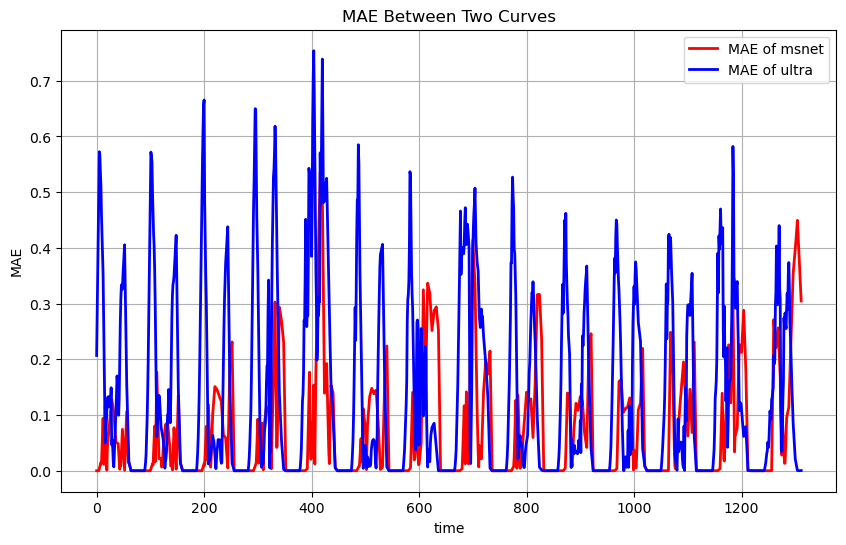

In [99]:
p_mae = np.abs(yy - tt)
u_mae = np.abs(com_test - tt)

plt.figure(figsize=(10, 6))
plt.plot(p_mae, label='MAE of msnet', color='r', linewidth=2)
plt.plot(u_mae, label='MAE of ultra', color='b', linewidth=2)
plt.title('MAE Between Two Curves')
plt.xlabel('time')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
x = calculate_mae(yy,tt)
y = calculate_mae(com_test,tt)
y,x

(0.1416634393220135, 0.07307152610255165)

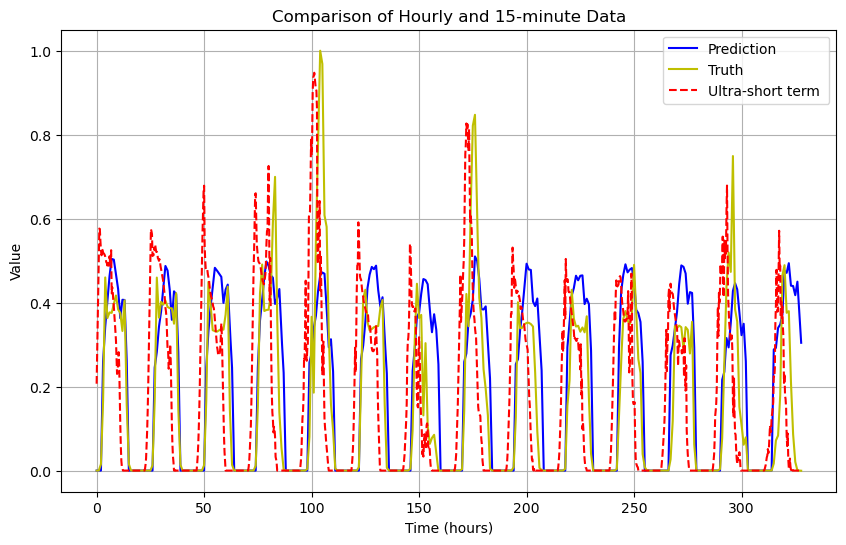

In [101]:
plt.figure(figsize=(10, 6))

# 绘制每小时的数据（插值后的数据）
plt.plot(time_15min, yy, label="Prediction", color='b')

plt.plot(time_15min, tt, label="Truth", color='y')

# 绘制每15分钟的数据
plt.plot(time_15min, com_test, label="Ultra-short term ", color='r', linestyle='--')

# 添加标签和标题
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.title("Comparison of Hourly and 15-minute Data")
plt.legend()
plt.grid(True)
plt.show()